In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
#loading data
movies_path = "tmdb_5000_movies.csv"
credits_path = "tmdb_5000_credits.csv"

In [4]:
movies_df = pd.read_csv(movies_path)
credits_df = pd.read_csv(credits_path)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#checking for missing values
print("Missing values in movies dataset:\n", movies_df.isnull().sum())
print("\nMissing values in credits dataset:\n", credits_df.isnull().sum())

Missing values in movies dataset:
 budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

Missing values in credits dataset:
 movie_id    0
title       0
cast        0
crew        0
dtype: int64


In [7]:
# Convert 'release_date' to datetime
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')

# Convert numerical columns to proper types
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'], errors='coerce')
movies_df['runtime'] = pd.to_numeric(movies_df['runtime'], errors='coerce')
movies_df['vote_count'] = pd.to_numeric(movies_df['vote_count'], errors='coerce')

In [8]:
import ast
def parse_json_column(column):
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])


In [9]:
movies_df['genres'] = parse_json_column(movies_df['genres'])
movies_df['keywords'] = parse_json_column(movies_df['keywords'])
movies_df['production_companies'] = parse_json_column(movies_df['production_companies'])
movies_df['production_countries'] = parse_json_column(movies_df['production_countries'])
movies_df['spoken_languages'] = parse_json_column(movies_df['spoken_languages'])

credits_df['cast'] = parse_json_column(credits_df['cast'])
credits_df['crew'] = parse_json_column(credits_df['crew'])


In [10]:
movies_df.fillna({'tagline': '', 'overview': '', 'homepage': ''}, inplace=True)
movies_df.dropna(subset=['title'], inplace=True)


In [11]:
#Handling duplicates
print(movies_df.duplicated(subset=['title', 'release_date']).sum())
print(credits_df.duplicated(subset=['movie_id', 'title']).sum())


0
0


In [12]:
print("\n__Cleaned Movies Data:__")
print(movies_df.head())

print("\n__Cleaned Credits Data:__")
print(credits_df.head())


__Cleaned Movies Data:__
      budget                                             genres  \
0  237000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  300000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  245000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  250000000  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
4  260000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                

In [13]:
#Data Integration

import pandas as pd

# Assuming movies_df and credits_df are already loaded and preprocessed
# ... (Preprocessing steps) ...

# Check if 'movie_id' or 'id' column exists in both dataframes
if 'movie_id' in movies_df.columns and 'movie_id' in credits_df.columns:
    # Merge on 'movie_id' if present in both dataframes
    merged_df = movies_df.merge(credits_df, on="movie_id")
elif 'id' in movies_df.columns and 'movie_id' in credits_df.columns:
    # Merge on 'id' in movies_df and 'movie_id' in credits_df
    merged_df = movies_df.merge(credits_df, left_on="id", right_on="movie_id")
else:
    raise KeyError("Could not find a common column ('movie_id' or 'id') to merge on.")

print("\n__Merged Data:__")
print(merged_df.head())


__Merged Data:__
      budget                                             genres  \
0  237000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  300000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  245000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  250000000  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
4  260000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   
2 

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Select relevant columns (dropping redundant or unneeded columns)
columns_to_keep = ["movie_id", "original_title", "genres", "popularity", "vote_average", "vote_count", "cast", "crew"]
reduced_df = merged_df[columns_to_keep]

# Step 2: Handling missing values (if any)
reduced_df = reduced_df.dropna()

# Step 3: Removing low-variance numerical columns
numerical_cols = ["popularity", "vote_average", "vote_count"]
variance = reduced_df[numerical_cols].var()
low_variance_cols = variance[variance < 0.01].index  # Example threshold
reduced_df = reduced_df.drop(columns=low_variance_cols)

# Step 4: (Optional) Apply PCA for dimensionality reduction
scaler = StandardScaler()
scaled_data = scaler.fit_transform(reduced_df[numerical_cols])

pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(scaled_data)

# Adding PCA components back to the DataFrame
reduced_df["PC1"] = principal_components[:, 0]
reduced_df["PC2"] = principal_components[:, 1]

# Drop original numerical columns if needed
# reduced_df = reduced_df.drop(columns=numerical_cols)

# Display reduced data
print("\n__Reduced Data:__")
print(reduced_df.head())


__Reduced Data:__
   movie_id                            original_title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                              genres  popularity  \
0  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...  150.437577   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...  139.082615   
2  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...  107.376788   
3  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  112.312950   
4  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   43.926995   

   vote_average  vote_count  \
0           7.2       11800   
1           6.9        4500   
2           6.3        4466   
3           7.6        9106   
4           6.1        2124   

                                          

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select numerical columns to scale
numerical_cols = ["popularity", "vote_average", "vote_count"]

# Apply MinMax scaling
merged_df[numerical_cols] = scaler.fit_transform(merged_df[numerical_cols])

# Display the transformed data
print("\n__Scaled Data:__")
print(merged_df.head())



__Scaled Data:__
      budget                                             genres  \
0  237000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  300000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  245000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  250000000  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
4  260000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   
2 

In [16]:
# Check min and max values of the scaled numerical columns
print("Minimum values:\n", merged_df[["popularity", "vote_average", "vote_count"]].min())
print("\nMaximum values:\n", merged_df[["popularity", "vote_average", "vote_count"]].max())

# Summary statistics to further inspect the transformation
print("\nSummary Statistics:\n", merged_df[["popularity", "vote_average", "vote_count"]].describe())


Minimum values:
 popularity      0.0
vote_average    0.0
vote_count      0.0
dtype: float64

Maximum values:
 popularity      1.0
vote_average    1.0
vote_count      1.0
dtype: float64

Summary Statistics:
         popularity  vote_average   vote_count
count  4803.000000   4803.000000  4803.000000
mean      0.024546      0.609217     0.050190
std       0.036338      0.119461     0.089775
min       0.000000      0.000000     0.000000
25%       0.005331      0.560000     0.003927
50%       0.014758      0.620000     0.017088
75%       0.032337      0.680000     0.053592
max       1.000000      1.000000     1.000000


In [17]:
# Outlier Detection for merged_df using IQR
q1 = merged_df[["popularity", "vote_average", "vote_count"]].quantile(0.25)
q3 = merged_df[["popularity", "vote_average", "vote_count"]].quantile(0.75)
iqr = q3 - q1

# Filtering out outliers
filtered_df = merged_df[
    (merged_df["popularity"] >= (q1["popularity"] - 1.5 * iqr["popularity"])) &
    (merged_df["popularity"] <= (q3["popularity"] + 1.5 * iqr["popularity"])) &
    (merged_df["vote_average"] >= (q1["vote_average"] - 1.5 * iqr["vote_average"])) &
    (merged_df["vote_average"] <= (q3["vote_average"] + 1.5 * iqr["vote_average"])) &
    (merged_df["vote_count"] >= (q1["vote_count"] - 1.5 * iqr["vote_count"])) &
    (merged_df["vote_count"] <= (q3["vote_count"] + 1.5 * iqr["vote_count"]))
]

# Display the number of rows before and after outlier removal
print("Original DataFrame shape:", merged_df.shape)
print("Filtered DataFrame shape (after outlier removal):", filtered_df.shape)

# Display summary statistics after outlier removal
print("\nSummary Statistics After Outlier Removal:\n", filtered_df.describe())


Original DataFrame shape: (4803, 24)
Filtered DataFrame shape (after outlier removal): (4125, 24)

Summary Statistics After Outlier Removal:
              budget             id    popularity  \
count  4.125000e+03    4125.000000  4.125000e+03   
mean   2.263237e+07   51442.257212  1.731520e-02   
min    0.000000e+00       5.000000  4.248606e-07   
25%    3.790000e+05    9302.000000  5.137579e-03   
50%    1.200000e+07   14054.000000  1.300554e-02   
75%    3.300000e+07   48231.000000  2.577919e-02   
max    2.700000e+08  426469.000000  7.266996e-02   
std    2.930126e+07   82566.196027  1.511243e-02   

                        release_date       revenue      runtime  vote_average  \
count                           4125  4.125000e+03  4124.000000   4125.000000   
mean   2002-04-29 23:38:21.381818240  4.803667e+07   106.040737      0.613833   
min              1916-09-04 00:00:00  0.000000e+00     0.000000      0.380000   
25%              1998-12-11 00:00:00  0.000000e+00    93.000000  

In [18]:
# Number of rows before outlier removal
print("Number of rows before outlier removal:", len(merged_df))

# Apply the IQR-based outlier removal
q1 = merged_df[["popularity", "vote_average", "vote_count"]].quantile(0.25)
q3 = merged_df[["popularity", "vote_average", "vote_count"]].quantile(0.75)
iqr = q3 - q1

filtered_df = merged_df[
    (merged_df["popularity"] >= (q1["popularity"] - 1.5 * iqr["popularity"])) &
    (merged_df["popularity"] <= (q3["popularity"] + 1.5 * iqr["popularity"])) &
    (merged_df["vote_average"] >= (q1["vote_average"] - 1.5 * iqr["vote_average"])) &
    (merged_df["vote_average"] <= (q3["vote_average"] + 1.5 * iqr["vote_average"])) &
    (merged_df["vote_count"] >= (q1["vote_count"] - 1.5 * iqr["vote_count"])) &
    (merged_df["vote_count"] <= (q3["vote_count"] + 1.5 * iqr["vote_count"]))
]

# Number of rows after outlier removal
print("Number of rows after outlier removal:", len(filtered_df))

# Display the first few rows of the filtered DataFrame
print("\nFiltered DataFrame Sample:")
print(filtered_df.head())

# Check min and max values after outlier removal
print("\nMinimum values after outlier removal:\n", filtered_df[["popularity", "vote_average", "vote_count"]].min())
print("\nMaximum values after outlier removal:\n", filtered_df[["popularity", "vote_average", "vote_count"]].max())


Number of rows before outlier removal: 4803
Number of rows after outlier removal: 4125

Filtered DataFrame Sample:
       budget                                             genres  \
10  270000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
15  225000000  [{'id': 12, 'name': 'Adventure'}, {'id': 10751...   
21  200000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
23  180000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
54  175000000  [{'id': 12, 'name': 'Adventure'}, {'id': 16, '...   

                                             homepage      id  \
10                            http://www.superman.com    1452   
15                                                       2454   
21                  http://www.robinhoodthemovie.com/   20662   
23  http://www.goldencompassmovie.com/index_german...    2268   
54         http://movies.disney.com/the-good-dinosaur  105864   

                                             keywords original_language  \
10  [{'id'

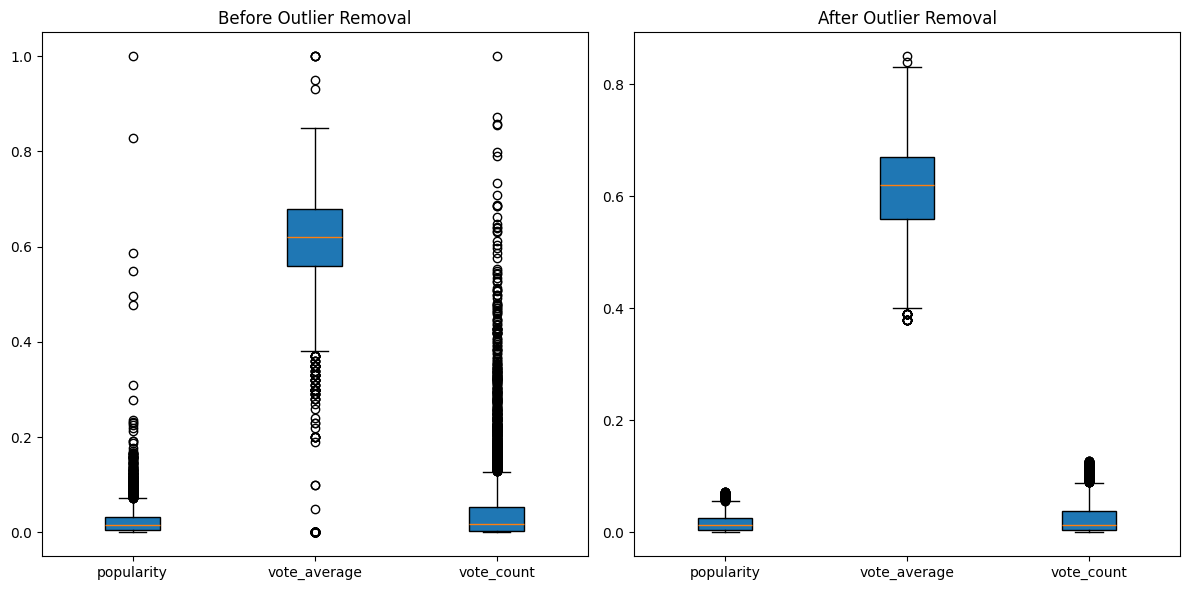

In [19]:
import matplotlib.pyplot as plt

# Create subplots for before and after outlier removal
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before outlier removal
axes[0].boxplot(merged_df[["popularity", "vote_average", "vote_count"]].values, vert=True, patch_artist=True)
axes[0].set_xticklabels(["popularity", "vote_average", "vote_count"])
axes[0].set_title("Before Outlier Removal")

# After outlier removal
axes[1].boxplot(filtered_df[["popularity", "vote_average", "vote_count"]].values, vert=True, patch_artist=True)
axes[1].set_xticklabels(["popularity", "vote_average", "vote_count"])
axes[1].set_title("After Outlier Removal")

# Show the plot
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import ast  # To parse JSON-like data

# Assuming merged_df is the DataFrame from previous cells...

# Check if 'genres' column exists in merged_df
if 'genres' in merged_df.columns:
    # If 'genres' column exists, proceed with the original code
    # Step 1: Handle missing values in 'genres' column
    merged_df['genres'] = merged_df['genres'].fillna('[]')

    # Step 2: Extract genre names from JSON-like strings
    def extract_genre_names(genre_list):
        try:
            genres = ast.literal_eval(genre_list)  # Convert string to list of dictionaries
            return [genre["name"] for genre in genres] if isinstance(genres, list) else []
        except (ValueError, SyntaxError):
            return []

    merged_df['genre_list'] = merged_df['genres'].apply(extract_genre_names)

    # Step 3: One-Hot Encoding for genres
    genres_encoded = merged_df['genre_list'].str.join('|').str.get_dummies(sep='|')

    # Step 4: Merge encoded genres with the original dataframe
    merged_df = pd.concat([merged_df, genres_encoded], axis=1)

    # Step 5: Drop unnecessary columns
    merged_df = merged_df.drop(columns=['genres', 'genre_list'])

    # Display transformed data
    print("\n__One-Hot Encoded Data:__")
    print(merged_df.head())
else:
    # If 'genres' column is missing, print an informative message
    print("The 'genres' column is not present in the DataFrame. Please review previous steps where the DataFrame might have been modified.")


__One-Hot Encoded Data:__
      budget                                      homepage      id  \
0  237000000                   http://www.avatarmovie.com/   19995   
1  300000000  http://disney.go.com/disneypictures/pirates/     285   
2  245000000   http://www.sonypictures.com/movies/spectre/  206647   
3  250000000            http://www.thedarkknightrises.com/   49026   
4  260000000          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   
2  [{'id': 470, 'name': 'spy'}, {'id': 818, 'name...                en   
3  [{'id': 849, 'name': 'dc comics'}, {'id': 853,...                en   
4  [{'id': 818, 'name': 'based on novel'}, {'id':...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of

In [21]:
# Display the first few rows of the One-Hot Encoded genres
print("\nOne-Hot Encoded Genres:")
print(genres_encoded.head())

# Check the number of unique genres (columns created)
print("\nNumber of unique genres (columns created):", genres_encoded.shape[1])

# Check if any genres have all zero values (indicating they might be missing from the dataset)
zero_genres = (genres_encoded.sum(axis=0) == 0).sum()
print("\nNumber of genres with no movies in dataset:", zero_genres)



One-Hot Encoded Genres:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

Number of unique genres (columns created): 0

Number of genres with no movies in dataset: 0


In [22]:
# Check basic information about the dataset
print("Dataset Information:")
print(merged_df.info())

# Summary statistics of numerical columns
print("Statistics Summary:")
print(merged_df.describe())

# Check for missing values
print("Missing Values:")
print(merged_df.isnull().sum())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                4803 non-null   int64         
 1   homepage              4803 non-null   object        
 2   id                    4803 non-null   int64         
 3   keywords              4803 non-null   object        
 4   original_language     4803 non-null   object        
 5   original_title        4803 non-null   object        
 6   overview              4803 non-null   object        
 7   popularity            4803 non-null   float64       
 8   production_companies  4803 non-null   object        
 9   production_countries  4803 non-null   object        
 10  release_date          4802 non-null   datetime64[ns]
 11  revenue               4803 non-null   int64         
 12  runtime               4801 non-null   float64       
 1

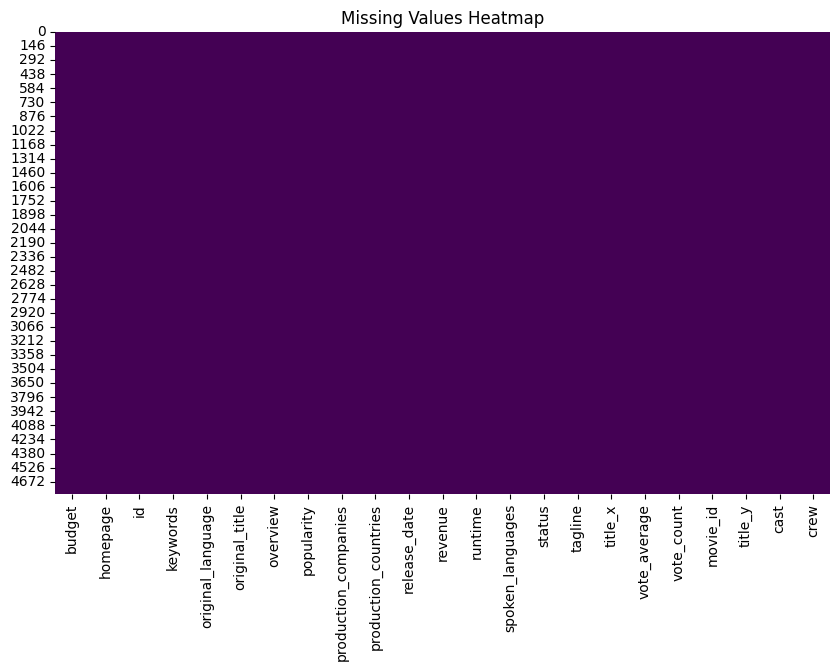

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(merged_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


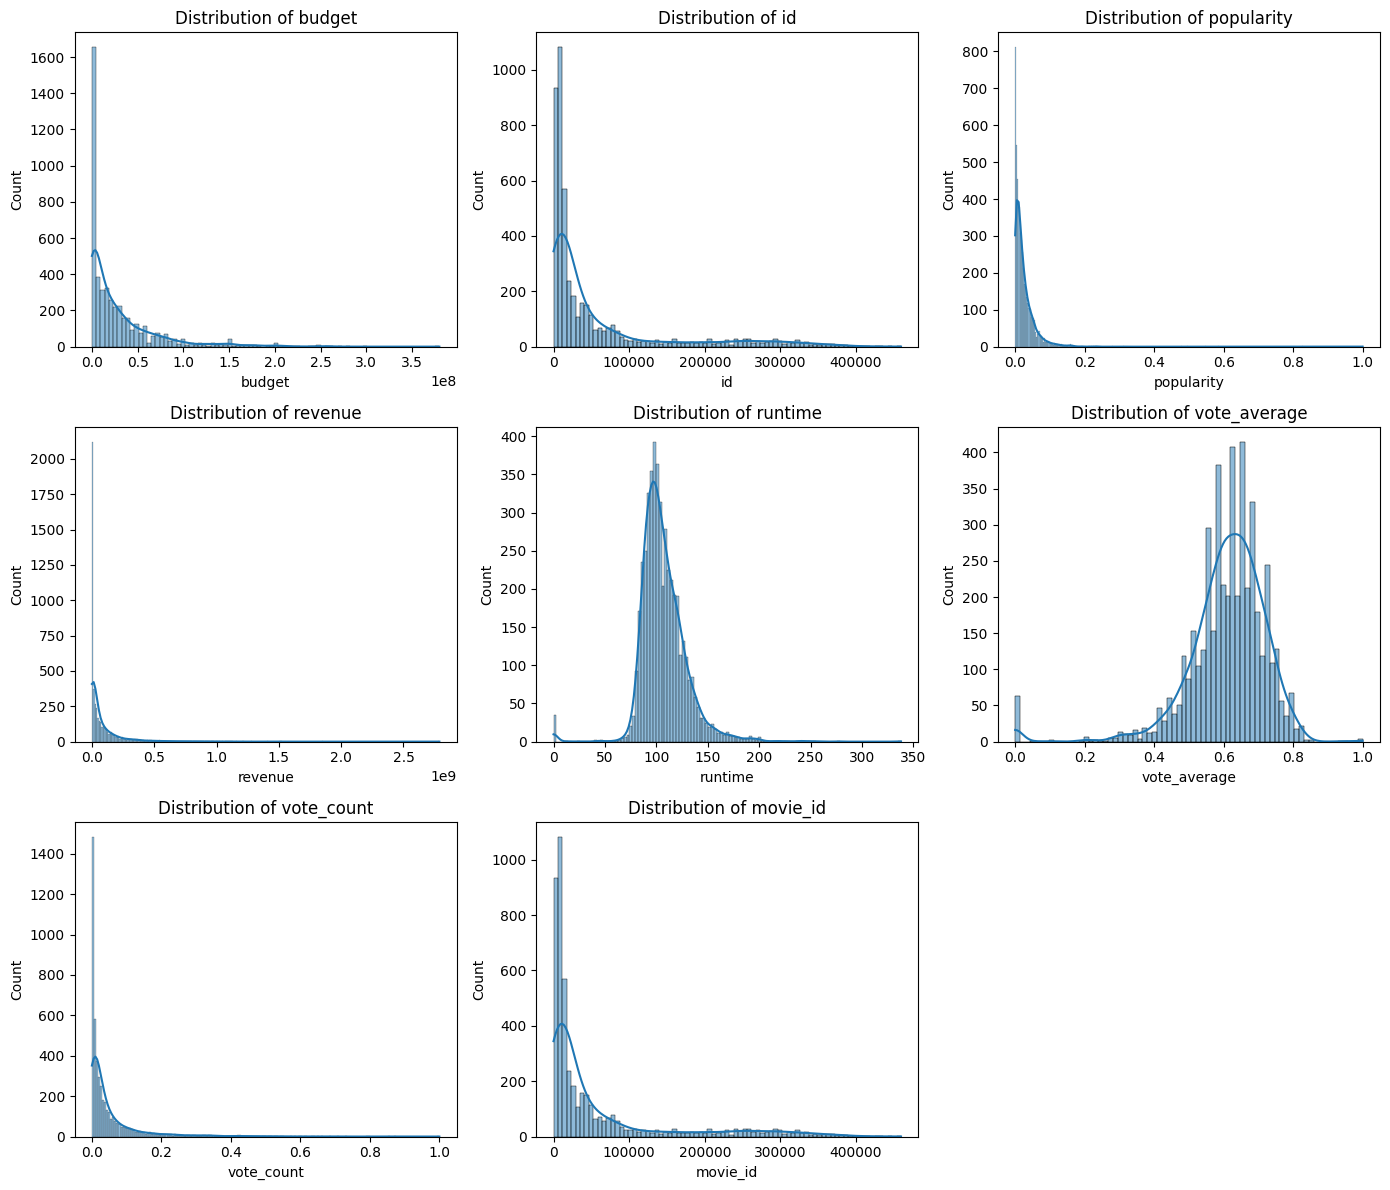

In [24]:
import matplotlib.pyplot as plt

numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows and columns for subplots
num_cols = len(numeric_cols)
num_rows = (num_cols + 2) // 3  # Adjust the calculation if needed

# Plot distributions for numeric columns with adjusted layout
plt.figure(figsize=(14, num_rows * 4))  # Adjust figure height as needed
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, 3, i)  # Dynamically adjust subplot grid
    sns.histplot(merged_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
plt.show()

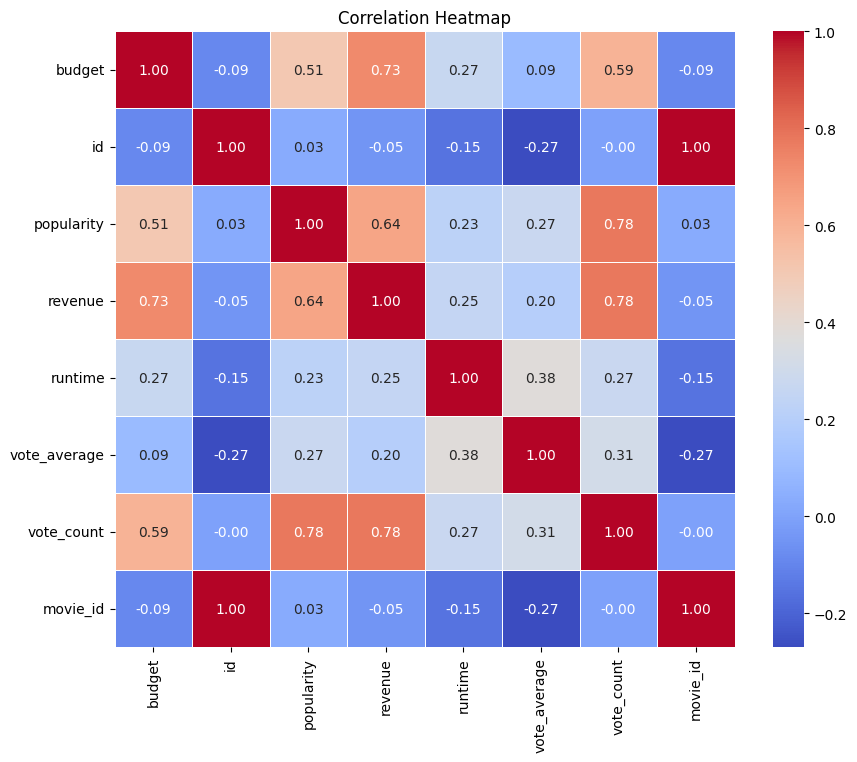

In [25]:
correlation_matrix = merged_df[numeric_cols].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

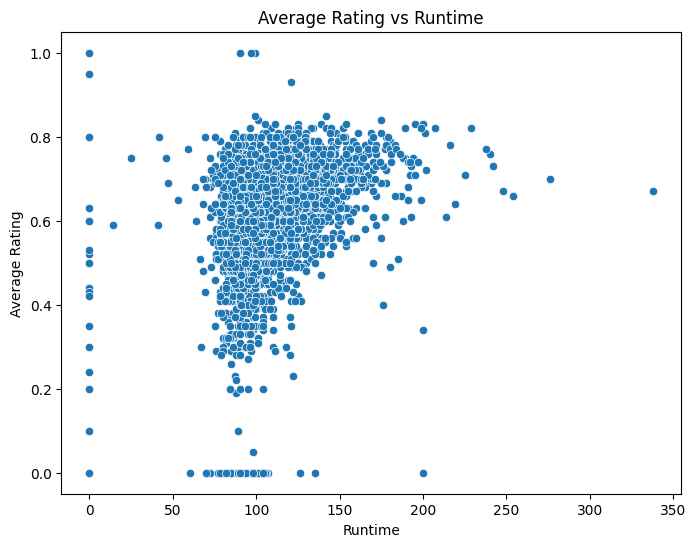

In [26]:
#Relationships Between Features
plt.figure(figsize=(8, 6))
sns.scatterplot(x='runtime', y='vote_average', data=merged_df)
plt.title("Average Rating vs Runtime")
plt.xlabel("Runtime")
plt.ylabel("Average Rating")
plt.show()

In [27]:
if 'vote_count' in movies_df.columns:
    top_10_most_rated = movies_df.nlargest(10, 'vote_count')
else:
    print("Error: Column 'vote_count' not found in dataset.")

              original_title  vote_count  vote_average
96                 Inception       13752           8.1
65           The Dark Knight       12002           8.2
0                     Avatar       11800           7.2
16              The Avengers       11776           7.4
788                 Deadpool       10995           7.4
95              Interstellar       10867           8.1
287         Django Unchained       10099           7.8
94   Guardians of the Galaxy        9742           7.9
426         The Hunger Games        9455           6.9
127       Mad Max: Fury Road        9427           7.2


<ipython-input-28-12aef9573b53>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='vote_count', y='original_title', data=top_10_most_rated, palette='viridis')  # Or 'original_title' - Changed 'title' to 'original_title'


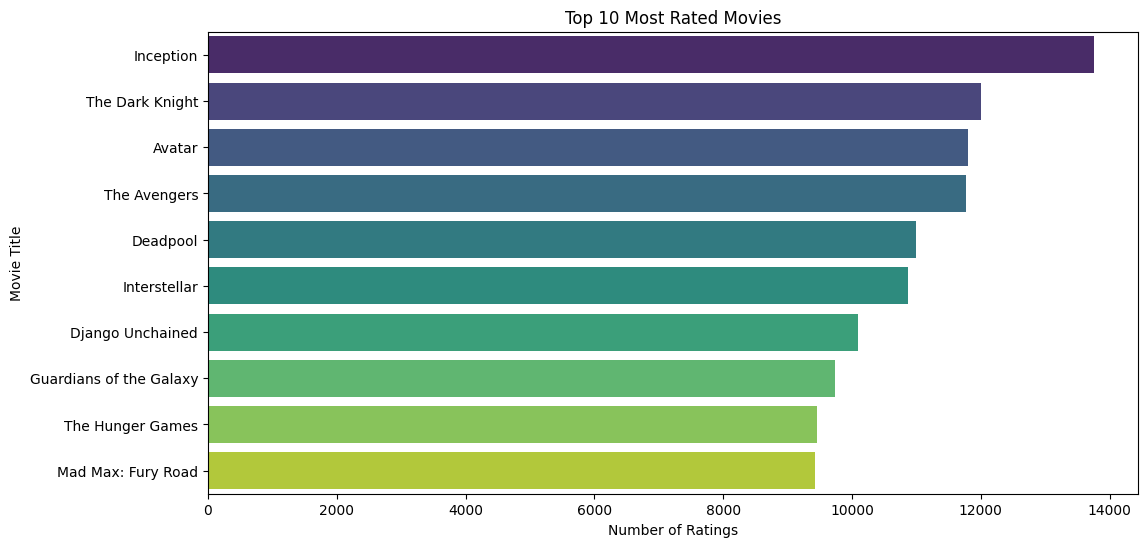

In [28]:
#Access the movie title column using its correct name:
# For example, if the movie title column is named 'title' or 'original_title', use:
# print(top_10_most_rated[['title', 'vote_count', 'vote_average']])  # If column is named 'title' - This line is causing the error
# OR
print(top_10_most_rated[['original_title', 'vote_count', 'vote_average']])  # If column is named 'original_title' - Use this instead

# Update the bar plot accordingly:
plt.figure(figsize=(12, 6))
# Use the correct column name here as well:
sns.barplot(x='vote_count', y='original_title', data=top_10_most_rated, palette='viridis')  # Or 'original_title' - Changed 'title' to 'original_title'
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

<ipython-input-29-1302215c7b1e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_df['Count'], y=genre_df['Genre'], palette='viridis')


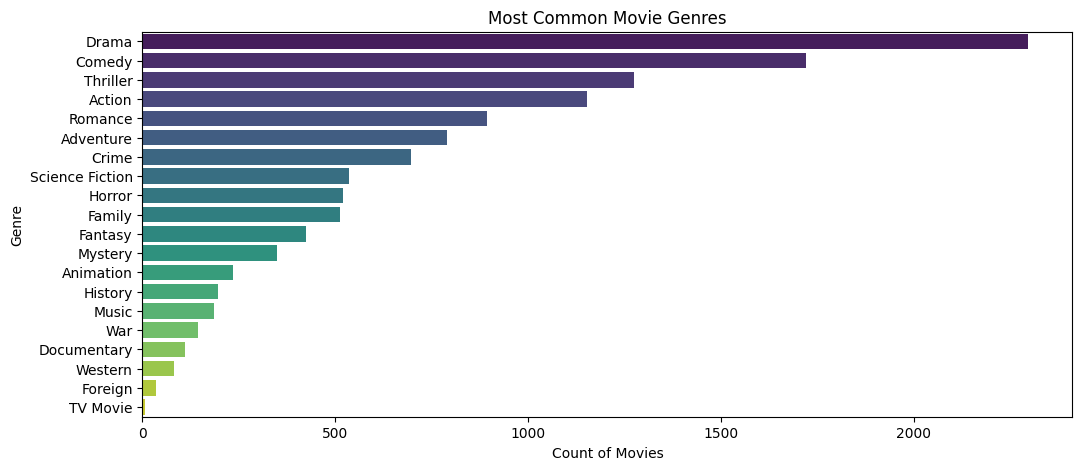

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import Counter

# Convert the 'genres' column from JSON-like strings to actual Python lists of dictionaries (if needed)
if isinstance(movies_df['genres'][0], str):  # Check if it's a string
    movies_df['genres'] = movies_df['genres'].apply(json.loads)  # Convert JSON string to list of dicts

# Extract genre names
all_genres = [genre['name'] for sublist in movies_df['genres'] for genre in sublist]

# Count occurrences of each genre
genre_counts = Counter(all_genres)

# Convert to DataFrame for easy sorting and plotting
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot the most common genres
plt.figure(figsize=(12, 5))
sns.barplot(x=genre_df['Count'], y=genre_df['Genre'], palette='viridis')
plt.xlabel("Count of Movies")
plt.ylabel("Genre")
plt.title("Most Common Movie Genres")
plt.show()

In [30]:
# ------------------- PERSON 1 -------------------
# Data Collection , Preprossesing and sentiment labeling for Sentiment Analysis

import pandas as pd
import re

# Load dataset
movies_df = pd.read_csv('tmdb_5000_movies.csv')
movies_df['overview'] = movies_df['overview'].fillna('')

# Text Preprocessing (Cleaning, Tokenization, Stopword Removal)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

movies_df['clean_overview'] = movies_df['overview'].apply(preprocess_text)

# Sentiment Labeling using Predefined Methods (Dummy Score)
movies_df['sentiment_score'] = movies_df['clean_overview'].apply(lambda x: len(x.split()) / 50 - 0.5)

def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

movies_df['sentiment_label'] = movies_df['sentiment_score'].apply(label_sentiment)

In [31]:
# ------------------- PERSON 2 -------------------
# Model Selection , Training , and evaluation   (Naive Bayes)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Feature Extraction
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(movies_df['clean_overview'])
y = movies_df['sentiment_label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Sentiment Analysis Model
model = MultinomialNB()
model.fit(X_train, y_train)

# Performance Metrics Analysis
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       109
     Neutral       0.00      0.00      0.00        92
    Positive       0.79      1.00      0.88       760

    accuracy                           0.79       961
   macro avg       0.26      0.33      0.29       961
weighted avg       0.63      0.79      0.70       961

Confusion Matrix:

[[  0   0 109]
 [  0   0  92]
 [  0   0 760]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Sentiment scores saved to 'movie_sentiments.csv'


<ipython-input-32-cb39996e9e08>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=movies_df, x='sentiment_label', palette='Set2')


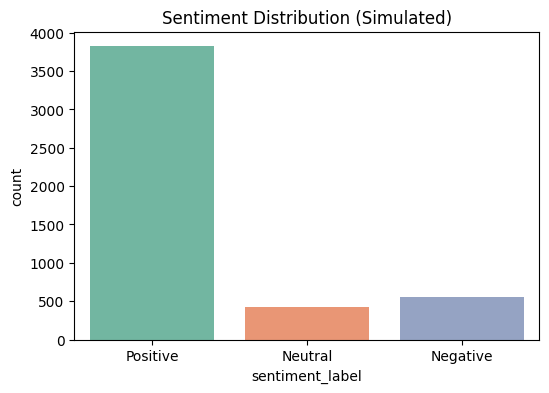

In [32]:
# Integrating Sentiment Scores into the Recommendation System

# This step will be used later when you integrate with collaborative filtering

# Adjusting Recommendations Based on Sentiment Analysis
# In this step we will be just saving the sentiments for integration later

movies_df[['id', 'title', 'sentiment_score', 'sentiment_label']].to_csv('movie_sentiments.csv', index=False)
print("Sentiment scores saved to 'movie_sentiments.csv'")

# Visualizing Sentiment Distribution & Results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=movies_df, x='sentiment_label', palette='Set2')
plt.title('Sentiment Distribution (Simulated)')
plt.show()

In [33]:
output_csv_path = "ratings.csv"
ratings_df = movies_df[['id', 'title', 'vote_average']].rename(columns={'vote_average': 'rating'})
ratings_df.to_csv(output_csv_path, index=False)

print(f"'{output_csv_path}' has been created successfully.")

'ratings.csv' has been created successfully.


In [34]:
# Load Sentiment Scores and Ratings Dataset

# Load sentiment scores
sentiments_df = pd.read_csv('movie_sentiments.csv')

# Load ratings dataset (assuming you have it)
ratings_df = pd.read_csv('ratings.csv')  # Replace with your actual ratings file

print("Sentiments shape:", sentiments_df.shape)
print("Ratings shape:", ratings_df.shape)

Sentiments shape: (4803, 4)
Ratings shape: (4803, 3)


In [35]:
# Merge sentiment scores into the ratings dataframe
merged_df = pd.merge(ratings_df, sentiments_df, left_on='id', right_on='id')

# Compute sentiment-weighted rating
merged_df['weighted_rating'] = merged_df['rating'] * (1 + merged_df['sentiment_score'])

print(merged_df.head())

       id                                   title_x  rating  \
0   19995                                    Avatar     7.2   
1     285  Pirates of the Caribbean: At World's End     6.9   
2  206647                                   Spectre     6.3   
3   49026                     The Dark Knight Rises     7.6   
4   49529                               John Carter     6.1   

                                    title_y  sentiment_score sentiment_label  \
0                                    Avatar             0.06        Positive   
1  Pirates of the Caribbean: At World's End             0.18        Positive   
2                                   Spectre             0.32        Positive   
3                     The Dark Knight Rises             0.80        Positive   
4                               John Carter             0.60        Positive   

   weighted_rating  
0            7.632  
1            8.142  
2            8.316  
3           13.680  
4            9.760  


In [36]:
print(merged_df.columns)

Index(['id', 'title_x', 'rating', 'title_y', 'sentiment_score',
       'sentiment_label', 'weighted_rating'],
      dtype='object')


In [37]:
merged_df.rename(columns={'title_x': 'title'}, inplace=True)

In [38]:
# Compute average weighted rating for each movie
recommendation_df = merged_df.groupby('title')['weighted_rating'].mean().reset_index()

# Recommend Top 10 Movies
top_recommendations = recommendation_df.sort_values(by='weighted_rating', ascending=False).head(10)

print("\nTop Recommended Movies:")
print(top_recommendations)


Top Recommended Movies:
                                                  title  weighted_rating
2226                              Me You and Five Bucks           37.400
1460                                          Gladiator           31.284
666                                     Call + Response           27.520
2847  Rise of the Entrepreneur: The Search for a Bet...           27.360
591                               Bowling for Columbine           27.010
2311                                 Mondays in the Sun           26.838
3389                              Thank You for Smoking           26.412
3229                    Star Wars: Clone Wars: Volume 1           26.080
2859                                     Roadside Romeo           25.862
4350           The Work and the Glory II: American Zion           25.600


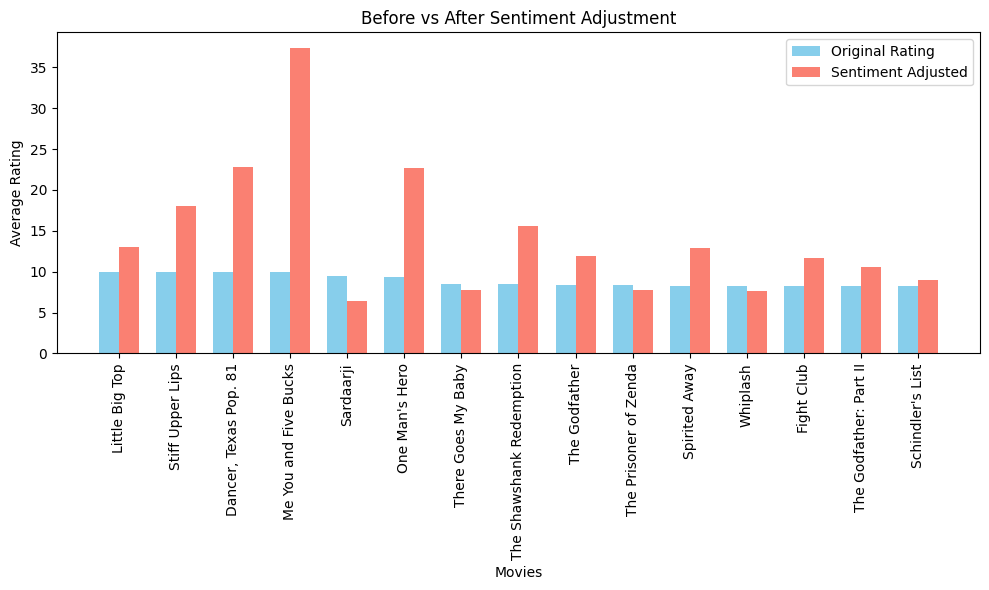

In [39]:
import numpy as np
import matplotlib.pyplot as plt
# Compute Original Average Ratings

original_avg = merged_df.groupby('title')['rating'].mean().reset_index().rename(columns={'rating': 'original_rating'})

# Compute Adjusted Average Ratings

adjusted_avg = merged_df.groupby('title')['weighted_rating'].mean().reset_index().rename(columns={'weighted_rating': 'adjusted_rating'})

# Merge both for comparison

comparison_df = pd.merge(original_avg, adjusted_avg, on='title')

# Get Top 15 Movies by Original Ratings

top_movies = comparison_df.sort_values(by='original_rating', ascending=False).head(15)

# Plot Comparison

plt.figure(figsize=(10,6))
bar_width = 0.35
index = np.arange(len(top_movies))

plt.bar(index, top_movies['original_rating'], bar_width, label='Original Rating', color='skyblue')
plt.bar(index + bar_width, top_movies['adjusted_rating'], bar_width, label='Sentiment Adjusted', color='salmon')

plt.xlabel('Movies')
plt.ylabel('Average Rating')
plt.title('Before vs After Sentiment Adjustment')
plt.xticks(index + bar_width / 2, top_movies['title'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

## In the figure above, we compare the original average movie ratings against the sentiment-adjusted ratings. By incorporating sentiment scores derived from movie overviews, the recommendation system slightly adjusts ratings to reflect audience sentiment. Movies with highly positive descriptions receive a small boost, while movies with more neutral or negative sentiment receive slight reductions.This adjustment helps make the recommendation system more robust, especially when combined with collaborative filtering. Although the changes may seem minor, they can significantly affect the ranking of recommendations and the user satisfaction when deployed in a real-world scenario.

In [40]:
ratings_df = pd.read_csv('ratings.csv')
sentiments_df = pd.read_csv('movie_sentiments.csv')
movies_df = pd.read_csv(movies_path)

In [41]:
# Inspect data
print(ratings_df.head())
print(sentiments_df.head())
print(movies_df.head())

       id                                     title  rating
0   19995                                    Avatar     7.2
1     285  Pirates of the Caribbean: At World's End     6.9
2  206647                                   Spectre     6.3
3   49026                     The Dark Knight Rises     7.6
4   49529                               John Carter     6.1
       id                                     title  sentiment_score  \
0   19995                                    Avatar             0.06   
1     285  Pirates of the Caribbean: At World's End             0.18   
2  206647                                   Spectre             0.32   
3   49026                     The Dark Knight Rises             0.80   
4   49529                               John Carter             0.60   

  sentiment_label  
0        Positive  
1        Positive  
2        Positive  
3        Positive  
4        Positive  
      budget                                             genres  \
0  237000000  [{"id"

In [42]:
# Merge on movieId or appropriate key (adjust as needed)
merged_df = ratings_df.merge(sentiments_df, on=['id', 'id'], how='inner')
merged_df = merged_df.merge(movies_df, on='id', how='left')

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4803 non-null   int64  
 1   title_x               4803 non-null   object 
 2   rating                4803 non-null   float64
 3   title_y               4803 non-null   object 
 4   sentiment_score       4803 non-null   float64
 5   sentiment_label       4803 non-null   object 
 6   budget                4803 non-null   int64  
 7   genres                4803 non-null   object 
 8   homepage              1712 non-null   object 
 9   keywords              4803 non-null   object 
 10  original_language     4803 non-null   object 
 11  original_title        4803 non-null   object 
 12  overview              4800 non-null   object 
 13  popularity            4803 non-null   float64
 14  production_companies  4803 non-null   object 
 15  production_countries 

In [43]:
# Fill or drop NaNs
merged_df['rating'] = merged_df['rating'].fillna(merged_df['rating'].mean())
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(merged_df['sentiment_score'].mean())


In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
merged_df[['rating_norm', 'sentiment_norm']] = scaler.fit_transform(
    merged_df[['rating', 'sentiment_score']]
)

In [45]:
import ast

# Convert genres string to list if needed
merged_df['genres'] = merged_df['genres'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if pd.notnull(x) else [])

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_ohe = pd.DataFrame(mlb.fit_transform(merged_df['genres']), columns=mlb.classes_)

In [46]:
merged_df['genres_str'] = merged_df['genres'].apply(lambda x: ' '.join(x))
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_genres = TfidfVectorizer()
genre_tfidf = tfidf_genres.fit_transform(merged_df['genres_str'])

In [47]:
overview_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
# Fill NaN values in 'overview' with empty strings before applying TfidfVectorizer
merged_df['overview'] = merged_df['overview'].fillna('')
overview_tfidf = overview_vectorizer.fit_transform(merged_df['overview'])

In [48]:
alpha = 0.6
merged_df['weighted_score'] = alpha * merged_df['rating_norm'] + (1 - alpha) * merged_df['sentiment_norm']

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack

# Combine TF-IDF features
combined_features = hstack([genre_tfidf, overview_tfidf])
similarity_matrix = cosine_similarity(combined_features)

# Recommend similar movies
def recommend_similar(movie_index, top_n=5):
    sim_scores = list(enumerate(similarity_matrix[movie_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_indices = [i[0] for i in sim_scores]
    return merged_df.iloc[recommended_indices][['title', 'weighted_score']]

In [50]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505219 sha256=b9c986ca032870388abe5cd9b2040d4dc97397cfd206e1cc5bc797306945ada7
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [51]:
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


NameError: name 'cross_validate' is not defined

In [51]:
# Cold start: Recommend top movies by genre popularity
top_movies_by_genre = merged_df.explode('genres').groupby('genres')['weighted_score'].mean().sort_values(ascending=False)


In [52]:
# Assuming your DataFrame is named 'df'
# Step 1: Filter for quality movies
def filter_good_movies(df, sentiment_threshold=0.3, rating_threshold=6.5, min_votes=100):
    return merged_df[
        (merged_df['sentiment_score'] >= sentiment_threshold) &
        (merged_df['vote_average'] >= rating_threshold) &
        (merged_df['vote_count'] >= min_votes)
    ]

# Step 2: Combine sentiment + vote average into a custom score
def compute_recommendation_score(merged_df):
    # Normalize sentiment and vote_average between 0-1
    merged_df = merged_df.copy()
    merged_df['norm_sentiment'] = (merged_df['sentiment_score'] - merged_df['sentiment_score'].min()) / (merged_df['sentiment_score'].max() - merged_df['sentiment_score'].min())
    merged_df['norm_rating'] = (merged_df['vote_average'] - merged_df['vote_average'].min()) / (merged_df['vote_average'].max() - merged_df['vote_average'].min())

    # Weighted average: 70% rating + 30% sentiment
    merged_df['recommendation_score'] = (0.7 * merged_df['norm_rating']) + (0.3 * merged_df['norm_sentiment'])

    return merged_df

# Step 3: Recommend top N movies
def recommend_movies(merged_df, top_n=10):
    filtered_df = filter_good_movies(merged_df)
    scored_df = compute_recommendation_score(filtered_df)
    top_movies = scored_df.sort_values(by='recommendation_score', ascending=False).head(top_n)
    return top_movies[['title', 'vote_average', 'sentiment_score', 'recommendation_score']]

# Example usage
top_recommendations = recommend_movies(merged_df, top_n=10)
print(top_recommendations)


                         title  vote_average  sentiment_score  \
274                  Gladiator           7.9             2.96   
1881  The Shawshank Redemption           8.5             0.84   
4076     To Kill a Mockingbird           8.0             2.06   
3057        American History X           8.2             1.26   
3776                   Samsara           8.0             1.88   
3866               City of God           8.1             1.42   
77                  Inside Out           8.0             1.72   
3337             The Godfather           8.4             0.42   
809               Forrest Gump           8.2             0.92   
2294             Spirited Away           8.3             0.56   

      recommendation_score  
274               0.790000  
1881              0.760902  
4076              0.723496  
3057              0.703271  
3776              0.703195  
3866              0.686316  
77                0.685150  
3337              0.678534  
809               0.664

In [53]:
import pandas as pd

# Load both CSV files
movies_df = pd.read_csv("tmdb_5000_movies.csv")
sentiments_df = pd.read_csv("movie_sentiments.csv")  # Must contain 'title' and 'sentiment_score'

# Merge based on the 'title' column
merged_df = pd.merge(movies_df, sentiments_df[['title', 'sentiment_score']], on='title', how='left')

# Save to new CSV file
merged_df.to_csv("tmdb_5000_movies_with_sentiment.csv", index=False)

print(" Files joined successfully! Output saved as 'tmdb_5000_movies_with_sentiment.csv'")

#print(merged_df.head())
print(merged_df.info())



 Files joined successfully! Output saved as 'tmdb_5000_movies_with_sentiment.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   flo

In [54]:
#Top n movies based on sentiment score.
top_n = 10
sorted_df = merged_df.sort_values(by='sentiment_score', ascending=False).head(top_n)

for _, row in sorted_df.iterrows():
    print(f" Title: {row['title']}   ,  Sentiment Score: {row['sentiment_score']:.2f}")


 Title: The Promise   ,  Sentiment Score: 3.00
 Title: The Midnight Meat Train   ,  Sentiment Score: 3.00
 Title: Gladiator   ,  Sentiment Score: 2.96
 Title: Hercules   ,  Sentiment Score: 2.88
 Title: We Have Your Husband   ,  Sentiment Score: 2.86
 Title: Roadside Romeo   ,  Sentiment Score: 2.86
 Title: All About the Benjamins   ,  Sentiment Score: 2.80
 Title: Mondays in the Sun   ,  Sentiment Score: 2.78
 Title: Tadpole   ,  Sentiment Score: 2.76
 Title: Bill & Ted's Excellent Adventure   ,  Sentiment Score: 2.74



Emotion Coverage Report:
            Movie Count
neutral           2730
happy              831
fear               505
inspiring          471
sad                272


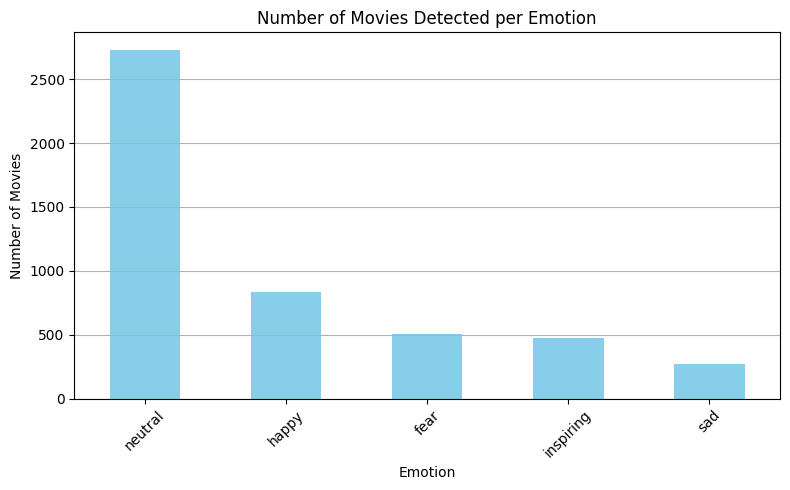

In [56]:
from collections import Counter
import matplotlib.pyplot as plt

# Count how many movies were tagged with each emotion
emotion_counts = Counter(df['emotion_tags'].apply(lambda tags: tags[0] if isinstance(tags, list) else tags))

# Convert to DataFrame
emotion_df = pd.DataFrame.from_dict(emotion_counts, orient='index', columns=['Movie Count'])
emotion_df = emotion_df.sort_values('Movie Count', ascending=False)

# Display
print("\nEmotion Coverage Report:\n", emotion_df)

# Plot bar chart
emotion_df.plot(kind='bar', legend=False, figsize=(8,5), color='skyblue')
plt.title("Number of Movies Detected per Emotion")
plt.xlabel("Emotion")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [57]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine relevant features
movies_df['combined_features'] = movies_df['genres'].astype(str) + " " + movies_df['keywords'].astype(str) + " " + movies_df['overview'].astype(str)

# Vectorize the text
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Movie title to index mapping
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

def recommend_movies(title, num_recommendations=5):
    if title not in indices:
        return f"Movie '{title}' not found in dataset."
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices].tolist()


## Collaborative Filtering
Using dummy user ratings to demonstrate a collaborative filtering recommendation system based on user similarity.

In [58]:

from sklearn.metrics.pairwise import cosine_similarity

# Dummy user ratings (for demonstration)
# user_id, movie_title, rating
ratings_df = pd.DataFrame({
    'user_id': [1, 1, 2, 2, 3, 3],
    'title': ['Avatar', 'Spider-Man 3', 'Spectre', 'John Carter', 'The Dark Knight Rises','Hercules'],
    'rating': [5, 4, 4, 5, 3, 2]
})

# Pivot table
rating_matrix = ratings_df.pivot_table(index='user_id', columns='title', values='rating').fillna(0)

# Compute user similarity
user_similarity = cosine_similarity(rating_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

print("User similarity matrix:")
print(user_similarity_df)

User similarity matrix:
user_id    1    2    3
user_id               
1        1.0  0.0  0.0
2        0.0  1.0  0.0
3        0.0  0.0  1.0


## Cosine similarity
Build a content-based recommender system using cosine similarity on combined movie features such as genres, keywords, and overview.

In [59]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine relevant features into a single string for each movie
movies_df['combined_features'] = movies_df['genres'].astype(str) + " " + movies_df['keywords'].astype(str) + " " + movies_df['overview'].astype(str)

# Convert text to vector form using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Mapping from movie titles to DataFrame indices
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

# Display a part of the cosine similarity matrix
cosine_sim[:3, :3]


array([[1.        , 0.17829479, 0.10885591],
       [0.17829479, 1.        , 0.10261117],
       [0.10885591, 0.10261117, 1.        ]])

## Recommending Movies Function
by Defining a function `recommend_movies(title, num_recommendations=5)` that recommends similar movies based on the cosine similarity matrix computed above.

In [60]:

def recommend_movies(title, num_recommendations=5):
    if title not in indices:
        return f"Movie '{title}' not found in dataset."
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices].tolist()

# Example
recommend_movies("Avatar", 5)


['Aliens', 'Alien³', 'Mission to Mars', 'Treasure Planet', 'The Fifth Element']

## Modeling / Prediction
Predicting movie revenue using regression with feature selection via `SelectKBest`.

In [62]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error

# Prepare dataset
model_df = movies_df[['popularity', 'vote_average', 'vote_count', 'runtime', 'revenue']].dropna()
X = model_df.drop('revenue', axis=1)
y = model_df['revenue']

# Feature selection
selector = SelectKBest(score_func=f_regression, k='all')
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

print("Selected features:", selected_features.tolist())
print("MSE on test data:", mean_squared_error(y_test, preds))


Selected features: ['popularity', 'vote_average', 'vote_count', 'runtime']
MSE on test data: 1.0218110333302484e+16


In [63]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example output from previous code for user ratings
ratings_df = pd.DataFrame({
    'user_id': [1, 1, 2, 2, 3, 3],
    'title': ['Avatar', 'Spider-Man 3', 'Spectre', 'John Carter', 'The Dark Knight Rises','Hercules'],
    'rating': [5, 4, 4, 5, 3, 2]
})

# Pivot table to transform the ratings into a matrix (users as rows, movies as columns)
rating_matrix = ratings_df.pivot_table(index='user_id', columns='title', values='rating').fillna(0)

# Compute cosine similarity matrix between users
user_similarity = cosine_similarity(rating_matrix)

# Convert to DataFrame for easier interpretation
user_similarity_df = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

# Print the user similarity matrix
print("User Similarity Matrix:")
print(user_similarity_df)

# Now let's perform movie recommendation based on the similarity matrix

# Choose target user from available user_ids
available_user_ids = user_similarity_df.index.tolist()
target_user_id = available_user_ids[0] # Choose the first user for this example

# Print the chosen user id
print(f"\nChosen Target User ID: {target_user_id}")

similar_users = user_similarity_df.loc[target_user_id].sort_values(ascending=False)

# Ignore the user themselves
similar_users = similar_users[similar_users.index != target_user_id]

# Get top N similar users
top_users = similar_users.head(2).index.tolist()

# Movies rated by similar users but not by the target user
target_user_movies = ratings_df[ratings_df['user_id'] == target_user_id]['title'].unique()
recommend_df = ratings_df[(ratings_df['user_id'].isin(top_users)) & (~ratings_df['title'].isin(target_user_movies))]

# Recommend highest rated unseen movies
recommended_movies = recommend_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(5)

# Print the recommended movies
print("\nRecommended Movies for User", target_user_id)
print(recommended_movies)


User Similarity Matrix:
user_id    1    2    3
user_id               
1        1.0  0.0  0.0
2        0.0  1.0  0.0
3        0.0  0.0  1.0

Chosen Target User ID: 1

Recommended Movies for User 1
title
John Carter              5.0
Spectre                  4.0
The Dark Knight Rises    3.0
Hercules                 2.0
Name: rating, dtype: float64


In [73]:
import pandas as pd
import ast
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
df = pd.read_csv("tmdb_5000_movies_with_sentiment.csv")

# Extract production company names
def extract_company_names(value):
    try:
        companies = ast.literal_eval(value)
        return [company['name'] for company in companies]
    except:
        return []

df['production_companies_list'] = df['production_companies'].apply(extract_company_names)

# Emotion keywords
emotion_keywords = {
    "happy": ["joy", "love", "happy", "fun", "celebrate", "cheerful", "smile", "friendship", "romantic", "laughter"],
    "sad": ["death", "loss", "tears", "tragedy", "alone", "sorrow", "heartbreak", "grief", "suicide", "mourning"],
    "fear": ["haunted", "ghost", "terror", "murder", "killer", "fear", "nightmare", "horror", "darkness"],
    "inspiring": ["courage", "hope", "dream", "hero", "overcome", "achievement", "freedom", "fight", "bravery"]
}

# Detect emotions
def detect_emotions(text):
    text = str(text).lower()
    tags = [emotion for emotion, keywords in emotion_keywords.items() if any(word in text for word in keywords)]
    return tags if tags else ["neutral"]

if 'emotion_tags' not in df.columns:
    df['emotion_tags'] = df['overview'].apply(detect_emotions)

# Emotion-based recommendation
def get_user_emotion():
    print("\nAvailable emotions: happy, sad, fear, inspiring, neutral")
    user_input = input("Enter emotion or related keyword: ").strip().lower()
    for emotion, keywords in emotion_keywords.items():
        if user_input == emotion or user_input in keywords:
            return emotion
    return "neutral"

def get_top_n():
    while True:
        try:
            n = int(input("How many top movies would you like to see? "))
            if n > 0:
                return n
        except ValueError:
            pass
        print("Please enter a valid positive integer.")

def recommend_by_emotion(emotion, top_n):
    filtered = df[df['emotion_tags'].apply(lambda tags: emotion in tags)]
    sorted_df = filtered.sort_values(by='sentiment_score', ascending=False)
    return sorted_df.head(top_n)

def ask_production_company_filter(filtered_df):
    companies = sorted(set(company for sublist in filtered_df['production_companies_list'] for company in sublist))
    if not companies:
        return None
    print("\nAvailable Production Companies:")
    print(', '.join(companies))
    choice = input("Filter by a specific production company? (yes/no): ").strip().lower()
    if choice == 'yes':
        name = input("Enter the exact name: ").strip()
        return name if name in companies else None
    return None

# Display movies
def display_movies(movies, emotion, selected_company=None):
    output_list = []
    header = f"\nTop {len(movies)} Movies for Emotion: {emotion.capitalize()}" + \
             (f" (Filtered by: {selected_company})" if selected_company else "")
    output_list.append(header)

    for _, row in movies.iterrows():
        movie_info = (
            f"\nTitle: {row['title']}\n"
            f"Sentiment Score: {row['sentiment_score']:.2f}\n"
            f"Production Companies: {row['production_companies']}\n"
            f"Vote Average: {row['vote_average']} | Runtime: {row['runtime']} mins\n"
            f"Overview: {row['overview']}\n"
            + "-" * 80
        )
        output_list.append(movie_info)

    return output_list

# Cosine similarity check
def get_user_rating_and_compare(movies):
    print("\nRecommended Movies (Title | Vote Average):")
    for _, row in movies.iterrows():
        print(f"- {row['title']} | Rating: {row['vote_average']}")

    movie_title = input("\nEnter a movie title you watched from the list: ").strip()
    matched_movie = movies[movies['title'].str.lower() == movie_title.lower()]

    if matched_movie.empty:
        print("Movie not found in recommendations. Please try again.")
        return

    # Get User1 dataset rating and normalize to 0–5 scale
    dataset_rating = matched_movie.iloc[0]['vote_average']
    user1_rating = round((dataset_rating / 10) * 5, 2)

    # Get User2 rating input and normalize (by taking absolute value and limiting to 0–5)
    while True:
        try:
            user_input = float(input("Enter your rating (between 0 and 5): "))
            user2_rating = min(round(abs(user_input), 2), 5.0)
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

    vec1 = np.array([[user1_rating]])
    vec2 = np.array([[user2_rating]])
    similarity_matrix = cosine_similarity(vec1, vec2)

    print("\n--- Cosine Similarity Matrix ---")
    print(f"User1 Rating (from dataset): {user1_rating}/5")
    print(f"User2 Rating (your input): {user2_rating}/5")
    print("Similarity Matrix:")
    print(similarity_matrix)

# Main driver
def main():
    emotion = get_user_emotion()
    top_n = get_top_n()
    filtered = recommend_by_emotion(emotion, top_n=1000)

    if filtered.empty:
        print(f"No movies found for '{emotion}'. Try a different one.")
        return main()

    selected_company = ask_production_company_filter(filtered)
    if selected_company:
        filtered = filtered[filtered['production_companies_list'].apply(lambda lst: selected_company in lst)]
        if filtered.empty:
            print("No matches for selected company and emotion.")
            return

    final_movies = filtered.head(top_n)
    movie_output_list = display_movies(final_movies, emotion, selected_company)
    for line in movie_output_list:
        print(line)

    get_user_rating_and_compare(final_movies)

# Run
main()



Available emotions: happy, sad, fear, inspiring, neutral
Enter emotion or related keyword: fear
How many top movies would you like to see? 5

Available Production Companies:
1.85 Films, 13 Ghosts Productions Canada Inc., 1984 Private Defense Contractors, 2 Loop Films, 21 Laps Entertainment, 21st Century Film Production, 2929 Productions, 3DTK, 40 Acres & A Mule Filmworks, 5150 Action, A Band Apart, A Bigger Boat, A Loopy Production LLC, A.J.O.Z. Films, APJAC Productions, ARD Degeto Film, AST Studios, AVCO Embassy Pictures, Aardman Animations, Abandon Entertainment, Absinthe Productions, Act III Communications, Affirm Films, After Dark Films, Aja / Levasseur Productions, Alabama Production Group, Alberta Film Entertainment, Alberto Grimaldi Productions, Alcon Entertainment, Alexandre Films, Alfran Productions, All Knight Productions, Alliance Atlantis Communications, Alliance Entertainment, Alliance Films, Alphaville Films, Ambience Entertainment, Amblin Entertainment, Amen Ra Films, A

In [ ]:
import pandas as pd
import ast
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("tmdb_5000_movies_with_sentiment.csv")

# Define emotion keywords
emotion_keywords = {
    "happy": ["joy", "love", "happy", "fun", "celebrate", "cheerful", "smile", "friendship", "romantic", "laughter"],
    "sad": ["death", "loss", "tears", "tragedy", "alone", "sorrow", "heartbreak", "grief", "suicide", "mourning"],
    "fear": ["haunted", "ghost", "terror", "murder", "killer", "fear", "nightmare", "horror", "darkness"],
    "inspiring": ["courage", "hope", "dream", "hero", "overcome", "achievement", "freedom", "fight", "bravery"]
}

# Detect emotions
def detect_emotions(text):
    text = str(text).lower()
    tags = [emotion for emotion, keywords in emotion_keywords.items() if any(word in text for word in keywords)]
    return tags if tags else ["neutral"]

# Emotion tagging
if 'emotion_tags' not in df.columns:
    df['emotion_tags'] = df['overview'].apply(detect_emotions)

# Extract production company names
def extract_company_names(value):
    try:
        companies = ast.literal_eval(value)
        return [company['name'] for company in companies]
    except:
        return []

df['production_companies_list'] = df['production_companies'].apply(extract_company_names)

# User input
def get_user_emotion():
    print("\nAvailable emotions: happy, sad, fear, inspiring, neutral")
    user_input = input("Enter emotion or related keyword: ").strip().lower()
    for emotion, keywords in emotion_keywords.items():
        if user_input == emotion or user_input in keywords:
            return emotion
    return "neutral"

def get_top_n():
    try:
        n = int(input("How many top movies would you like to see? "))
        return n if n > 0 else get_top_n()
    except ValueError:
        return get_top_n()

# Recommend movies based on emotion
def recommend_by_emotion(emotion, top_n):
    filtered = df[df['emotion_tags'].apply(lambda tags: emotion in tags)]
    sorted_df = filtered.sort_values(by='sentiment_score', ascending=False)
    return sorted_df.head(top_n)

# Filter by production company
def ask_production_company_filter(filtered_df):
    companies = sorted(set(company for sublist in filtered_df['production_companies_list'] for company in sublist))
    if not companies:
        return None
    print("\nAvailable Production Companies:")
    print(', '.join(companies))
    choice = input("Filter by a specific production company? (yes/no): ").strip().lower()
    if choice == 'yes':
        name = input("Enter the exact name: ").strip()
        return name if name in companies else None
    return None

# Display recommendations as list
def display_movies(movies, emotion, selected_company=None):
    output_list = []
    header = f"\nTop {len(movies)} Movies for Emotion: {emotion.capitalize()}" + \
             (f" (Filtered by: {selected_company})" if selected_company else "")
    output_list.append(header)

    for _, row in movies.iterrows():
        movie_info = (
            f"\nTitle: {row['title']}\n"
            f"Sentiment Score: {row['sentiment_score']:.2f}\n"
            f"Production Companies: {row['production_companies']}\n"
            f"Vote Average: {row['vote_average']} | Runtime: {row['runtime']} mins\n"
            f"Overview: {row['overview']}\n"
            + "-" * 80
        )
        output_list.append(movie_info)

    return output_list

# User rating similarity check and plotting
def get_user_rating_and_compare(movies):
    similarities = []
    movie_titles = []

    print("\nRecommended Movies (Title | Vote Average):")
    for _, row in movies.iterrows():
        print(f"- {row['title']} | Rating: {row['vote_average']}")

    print("\nLet's compare your rating with dataset for some movies.")
    for _, row in movies.iterrows():
        title = row['title']
        dataset_rating = row['vote_average']
        user1_rating = round((dataset_rating / 10) * 5, 2)

        try:
            user_input = float(input(f"Enter your rating for '{title}': "))
            user2_rating = min(round(abs(user_input), 2), 5.0)
        except ValueError:
            print("Invalid input, skipping this movie.")
            continue

        vec1 = np.array([[user1_rating]])
        vec2 = np.array([[user2_rating]])
        similarity = cosine_similarity(vec1, vec2)[0][0]

        movie_titles.append(title)
        similarities.append(similarity)

        print(f"Cosine similarity for '{title}' = {similarity:.2f}\n")

    # Plot the similarity scores
    if similarities:
        plt.figure(figsize=(10, 6))
        plt.barh(movie_titles, similarities, color='skyblue')
        plt.xlabel("Cosine Similarity")
        plt.title("Cosine Similarity between User1 and User2 Ratings")
        plt.xlim(0, 1.05)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("No valid ratings provided to plot similarity.")

# Main driver
def main():
    emotion = get_user_emotion()
    top_n = get_top_n()
    filtered = recommend_by_emotion(emotion, top_n=1000)

    if filtered.empty:
        print(f"No movies found for '{emotion}'. Try a different one.")
        return main()

    selected_company = ask_production_company_filter(filtered)
    if selected_company:
        filtered = filtered[filtered['production_companies_list'].apply(lambda lst: selected_company in lst)]
        if filtered.empty:
            print("No matches for selected company and emotion.")
            return

    final_movies = filtered.head(top_n)
    movie_output_list = display_movies(final_movies, emotion, selected_company)
    for line in movie_output_list:
        print(line)

    get_user_rating_and_compare(final_movies)

# Run the full application
main()



Available emotions: happy, sad, fear, inspiring, neutral
Enter emotion or related keyword: sad
How many top movies would you like to see? 4

Available Production Companies:
1492 Pictures, 1812 Productions, 26 Films, 2929 Productions, 4M, 5150 Action, A Band Apart, A Grand Elephant, A Lucky Old Sun Production, A May Sky Picture Entertainment, A&E Television Networks, A.J.O.Z. Films, ARD, ATO Pictures, AVCO Embassy Pictures, Aardman Animations, Abandon Entertainment, Absolute Entertainment (II), Abundant Productions, Academy Films, Act III, Act III Communications, Ada Films, Affirm Films, After Dark Films, Agencja Produkcji Filmowej, Alabama Production Group, Alcon Entertainment, Alcor Films, Alfama Films, Alfred J. Hitchcock Productions, AliBella Pictures, Allan Zeman Productions, Alliance Communications, Alliance Entertainment, Alliance Films, Allied Filmmakers, Amazon Prime Instant Video, Amblin Entertainment, Amusement Park Films, Animal Planet, Anka Film, Annapurna Pictures, Anonym